In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook

In [10]:
THRESHOLD= -30.0

CM  = 1.00  # /*uF/cm2*/
I_STIM = 2.0 # /*uA/cm2*/

E_NA =  50.0
E_K  = -100.0
E_L  = -67

E_SYN_H = -75

G_NA = 100 
G_K =  80
G_L  = 0.1
G_CHR = 0*0.09115

#--------SYNAPTIC PARAMETERS-----------#

TAU_RISE = 0.25
TAU_FALL = 3

g_syn = 0.0214844/5

G_SYN = 24*g_syn # 24 inhibitory synapses as input to the single excitatory neuron

#-------Function Definitions----------#

def alpha_m(v):
    return((0.32*(v+54))/(1-np.exp(-(v+54)/4)))

def beta_m(v):
    return((0.28*(v+27))/(np.exp((v+27)/5) - 1))

def alpha_h(v):
    return(0.128*np.exp(-(v+50)/18))

def beta_h(v):
    return(4/(1+np.exp(-(v+27)/5)))

def alpha_n(v):
    return((0.032*(v+52))/(1-np.exp(-(v+52)/5)))

def beta_n(v):
    return(0.5*np.exp(-(v+57)/40))

#------------- Functions Definitions for Currents ---------------#
def I_NA(V, M, H): return G_NA * (M**3) * H * (E_NA - V)
def I_L(V): return G_L * (E_L - V)
def I_K(V,N): return G_K * (N**4) * (E_K - V)
def I_Syn(V,gsyn1):   return gsyn1 * (E_SYN_H - V)
def I_CHR(V):   return -G_CHR * V
#def I_S2(V):   return G_SYN2 * V
#def I_S3(V,G): return G * (V - E_SYN_H)

In [11]:
def Euler_Stellate(intitial_values,tf,N):
    t = np.linspace(0,tf,N+1)
    dt = tf/N

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    M = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    M[0] = initial_values[1]
    H[0] = initial_values[2]
    N[0] = initial_values[3]

    sol = [initial_values]
    
    for i in range(len(t) - 1):   
        V[i+1] = V[i] + dt*(((I_STIM +I_CHR(V[i]) + I_NA(V[i],M[i],H[i]) + I_K(V[i],N[i]) + I_L(V[i]))) / CM)
        M[i+1] = M[i] + dt*(alpha_m(V[i])*(1 - M[i]) - beta_m(V[i])*M[i])
        H[i+1] = H[i] + dt*(alpha_h(V[i])*(1 - H[i]) - beta_h(V[i])*H[i])
        N[i+1] = N[i] + dt*(alpha_n(V[i])*(1 - N[i]) - beta_n(V[i])*N[i])
        sol+=[[V[i+1], M[i+1], H[i+1], N[i+1]]]   
    return sol 

120000
The spike times of a free running neuron are [0.0, 15.117, 30.237000000000002, 45.357, 60.477000000000004, 75.59700000000001, 90.718, 105.83800000000001]
[15.117, 15.120000000000001, 15.119999999999997, 15.120000000000005, 15.120000000000005, 15.120999999999995, 15.120000000000005]


(0.0, 120.0)

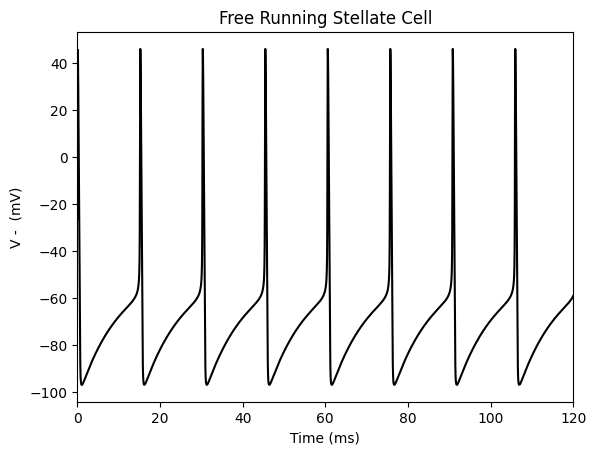

In [12]:
tf = 120
N = 120000
print(N)
t = np.linspace(0,tf,N+1)

initial_values = [-26.306,0.423,0.9389,0.17147]
sol = Euler_Stellate(initial_values,tf,N)

V = np.zeros(N+1)
#M = np.zeros(N+1)
#H = np.zeros(N+1)
#N = np.zeros(N+1)
j = 0

for i in range(len(sol)):
    #print('i of rows each time',sol[i][0])
    V[j] = sol[i][0]
#    M[j] = sol[i][1]
#    H[j] = sol[i][2]
#    N[j] = sol[i][3]
    j = j+1
    
itemindex = np.where(V[:] >= THRESHOLD)
#print(itemindex)

for index in itemindex:
    spike_times = t[index]
    #print(V[index],M[index],H[index],N[index])
    
#print(spike_times)

previous = spike_times[0]
actual_spikes = []
actual_spikes.append(previous)   
for i in range(len(spike_times)):
    if (spike_times[i] - previous > 3 ):
        actual_spikes.append(spike_times[i])
    previous = spike_times[i]

free_running_exc = actual_spikes
print('The spike times of a free running neuron are',free_running_exc)

difference = []

initial = actual_spikes[0]
for spikes in actual_spikes:
    difference.append(spikes - initial)
    initial = spikes

length_free_exc = []

for j in range(len(difference)):
    if(j>0):length_free_exc.append(difference[j])

print(length_free_exc)


plt.figure()
plt.title('Free Running Stellate Cell')
plt.plot(t,V, 'k', label='V')
plt.ylabel('V -  (mV)')
plt.xlabel('Time (ms)')
plt.xlim([0, tf])
#plt.ylim([-70, 10])

#plt.figure()
#plt.title('Self Connections')
#plt.plot(t,X1, 'k', label='V1')
#plt.ylabel('X1 (mV)')
#plt.xlabel('Time (mS)')
#plt.xlim([0, tf])

In [13]:
def Stellate_Perturb(intitial_values,tf,N,ts):
    t = np.linspace(0,tf,N+1)
    dt = tf/N

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    M = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    M[0] = initial_values[1]
    H[0] = initial_values[2]
    N[0] = initial_values[3]

    sol = [initial_values]
    
    gsyn = 0
    arg = (TAU_RISE*TAU_FALL) * ((np.log(TAU_FALL/TAU_RISE))/(TAU_FALL-TAU_RISE))
    f = 1.0/(np.exp(-arg/TAU_FALL) - np.exp(-arg/TAU_RISE))
    
    for i in range(len(t) - 1): 
        if (t[i] < ts): 
            gsyn = 0.0 #Allowing the first three spikes as a freely oscillating neuron 
        else:
            gsyn = f*G_SYN*(np.exp((ts - t[i])/TAU_FALL) - np.exp((ts - t[i])/TAU_RISE))

        V[i+1] = V[i] + dt*((I_STIM + I_CHR(V[i]) + I_NA(V[i],M[i],H[i]) + I_K(V[i],N[i]) + I_L(V[i]) + I_Syn(V[i],gsyn) ) / CM)
        M[i+1] = M[i] + dt*(alpha_m(V[i])*(1 - M[i]) - beta_m(V[i])*M[i])
        H[i+1] = H[i] + dt*(alpha_h(V[i])*(1 - H[i]) - beta_h(V[i])*H[i])
        N[i+1] = N[i] + dt*(alpha_n(V[i])*(1 - N[i]) - beta_n(V[i])*N[i])
        sol+=[[V[i+1], M[i+1], H[i+1], N[i+1]]]   
    return sol 

The spike times of a free running neuron are [0.0, 15.117, 30.237000000000002, 45.357, 60.477000000000004, 75.59700000000001, 90.718, 105.83800000000001]
The spike times of a perturbed neuron are [0.0, 15.117, 30.237000000000002, 46.959, 62.007, 77.127, 92.247, 107.367]
[15.117, 15.120000000000001, 16.722, 15.047999999999995, 15.119999999999997, 15.120000000000005, 15.120000000000005]


(0.0, 120.0)

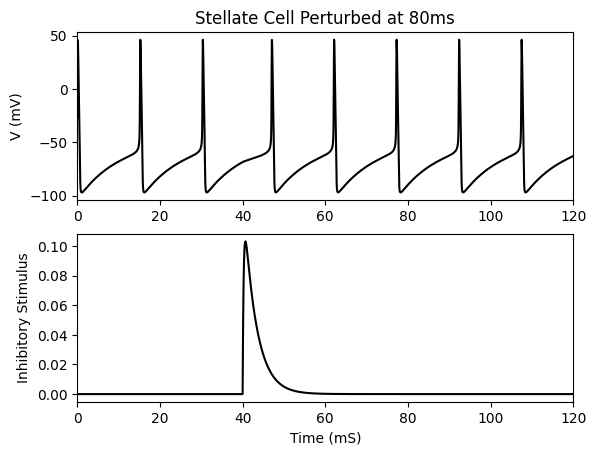

In [14]:
ts = 40
tf = 120
N = 120000
t = np.linspace(0,tf,N+1)
stimulus = np.zeros(len(t))
I_Syn_check = np.zeros(len(t))
j = 0

arg = (TAU_RISE*TAU_FALL) * ((np.log(TAU_FALL/TAU_RISE))/(TAU_FALL-TAU_RISE))
f = 1.0/(np.exp(-arg/TAU_FALL) - np.exp(-arg/TAU_RISE))

for time in t:
    if (time < ts): 
        stimulus[j] = 0.0
        j = j+1
    else:
        stimulus[j] = f*G_SYN*(np.exp((ts - time)/TAU_FALL) - np.exp((ts - time)/TAU_RISE))
        #print(j,stimulus[j])
        j = j+1


initial_values = [-26.306,0.423,0.9389,0.17147]
sol = Stellate_Perturb(initial_values,tf,N,ts)

V = np.zeros(N+1)

k = 0
for i in range(len(sol)):
    #print('i of rows each time',sol[i][0])
    V[k] = sol[i][0]
    #print(T[j],V1[j])
    k = k+1
    
itemindex = np.where(V[:] >= THRESHOLD)
#print(itemindex)

for index in itemindex:
    spike_times = t[index]
    
#print(spike_times)

previous = spike_times[0]
actual_spikes = []
actual_spikes.append(previous)   
for i in range(len(spike_times)):
    if (spike_times[i] - previous > 7 ):
        actual_spikes.append(spike_times[i])
    previous = spike_times[i]

single_stimulus_exc = actual_spikes
print('The spike times of a free running neuron are',free_running_exc)
print('The spike times of a perturbed neuron are',single_stimulus_exc)

difference = []

initial = actual_spikes[0]
for spikes in actual_spikes:
    difference.append(spikes - initial)
    initial = spikes

length_perturbed = []

for j in range(len(difference)):
    if(j>0):length_perturbed.append(difference[j])

print(length_perturbed)

plt.figure()
plt.subplot(2,1,1)
plt.title('Stellate Cell Perturbed at 80ms')
plt.plot(t,V, 'k', label='V')
plt.ylabel('V (mV)')
#plt.xlabel('Time (mS)')
plt.xlim([0, tf])
#plt.xlim([5, 15])
#plt.ylim([-70, 10])

plt.subplot(2,1,2)
plt.plot(t,stimulus, 'k', label='V')
plt.ylabel('Inhibitory Stimulus')
plt.xlabel('Time (mS)')
plt.xlim([0, tf])


In [15]:
T1 = free_running_exc[3]
T2 = free_running_exc[4]
period_free = T2-T1
epsilon = 0.01
#prc_interval = np.arange(T1+epsilon, T2-epsilon, epsilon)
prc_interval = np.linspace(T1+epsilon, T2, 100)
stim_interval = prc_interval-T1
phase = stim_interval/period_free

prc_readings = np.zeros((len(prc_interval),1))
output = np.zeros((len(prc_interval),2))

ts = T1 + epsilon
j=0
for ts in prc_interval:
    tf = 120
    N = 120000
    t = np.linspace(0,tf,N+1)
    
    initial_values = [-26.306,0.423,0.9389,0.17147]
    sol = Stellate_Perturb(initial_values,tf,N,ts)

    V = np.zeros(N+1)

    k = 0
    for i in range(len(sol)):
        #print('i of rows each time',sol[i][0])
        V[k] = sol[i][0]
        k = k+1
    
    itemindex = np.where(V[:] > THRESHOLD)
    
    for index in itemindex:
        spike_times = t[index]
        
    previous = spike_times[0]
    actual_spikes = []
    actual_spikes.append(previous)   
    for i in range(len(spike_times)):
        if (spike_times[i] - previous > 5 ):
            actual_spikes.append(spike_times[i])
        previous = spike_times[i]
    #print(j,ts,actual_spikes)
    diff_timings = np.zeros(len(actual_spikes))
    diff_timings = (actual_spikes[4] - actual_spikes[3]) - (free_running_exc[4] - free_running_exc[3])
    #print(diff_timings,diff_timings.shape)

    #prc_readings.append(diff_timings)
    prc_readings[j,:] = diff_timings/period_free
    output[j,0] = phase[j]
    output[j,1:] = diff_timings/period_free
    print(output[j,:])
    j = j+1

[ 0.00066138 -0.04160053]
[ 0.01075571 -0.04318783]
[ 0.02085003 -0.04470899]
[ 0.03094436 -0.04609788]
[ 0.04103869 -0.04708995]
[ 0.05113302 -0.04748677]
[ 0.06122735 -0.0468254 ]
[ 0.07132168 -0.04537037]
[ 0.08141601 -0.04338624]
[ 0.09151034 -0.04113757]
[ 0.10160467 -0.03869048]
[ 0.111699   -0.03617725]
[ 0.12179333 -0.03366402]
[ 0.13188766 -0.03108466]
[ 0.14198199 -0.02843915]
[ 0.15207632 -0.02585979]
[ 0.16217065 -0.02321429]
[ 0.17226498 -0.02056878]
[ 0.18235931 -0.01785714]
[ 0.19245364 -0.01521164]
[ 0.20254797 -0.0125    ]
[ 0.2126423  -0.00978836]
[ 0.22273663 -0.00701058]
[ 0.23283096 -0.00429894]
[ 0.24292528 -0.00152116]
[0.25301961 0.00125661]
[0.26311394 0.00403439]
[0.27320827 0.00681217]
[0.2833026  0.00965608]
[0.29339693 0.01243386]
[0.30349126 0.01527778]
[0.31358559 0.01812169]
[0.32367992 0.02096561]
[0.33377425 0.02380952]
[0.34386858 0.02665344]
[0.35396291 0.02949735]
[0.36405724 0.03234127]
[0.37415157 0.03525132]
[0.3842459  0.03809524]
[0.39434023 0.

(0.0, 1.0)

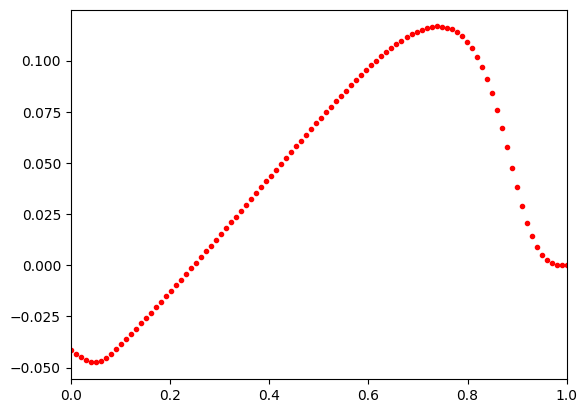

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
#plt.title('PRCs for Single due to Network with delay of 5.1ms')
plt.plot(phase, prc_readings, 'r.', label='1st Order')
#plt.axvline(x = (4.8/5.9733),color='k',linestyle='--')
#plt.ylabel('Phase Resetting')
#plt.xlabel('Phase')
#plt.savefig('PRC_Single.eps', format='eps')
#plt.legend()


#ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
#ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlim([0, 1])
#plt.savefig('PRC_Cluster2SC_Hyper_75.eps', format='eps')

In [17]:
df = pd.DataFrame(output, columns=['Phase', 'First_Order'])
df.to_excel('PRC_Cluster2SC_Fast.xlsx', sheet_name='Single2SC')